In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display

In [2]:
df = pd.read_csv("SPY.csv", usecols = ["Date", "Open", "High", "Low", "Close"])
df.isnull().any()
df["Date"] = pd.to_datetime(df["Date"])
df.index = df.pop("Date")
df1 = df.filter(["Close"])
data = df1.values


In [3]:
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
training_data = scaled_data[0:math.ceil(len(data) * .8), :]

In [4]:
steps = 30
x_training = [training_data[i-steps:i, 0] for i in range(steps, len(training_data))]
y_training = [training_data[i, 0] for i in range(steps, len(training_data))]
x_training, y_training = np.array(x_training), np.array(y_training)
x_training_3d = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))

In [5]:
model = Sequential()
model.add(LSTM(90, return_sequences=True, input_shape=(x_training_3d.shape[1], 1)))
model.add(Dropout(.3))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(.3))
model.add(LSTM(90, return_sequences=False))
model.add(Dropout(.3))
model.add(Dense(1))

In [6]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
model.fit(x_training_3d, y_training, batch_size=30, epochs=30)

Epoch 1/30
35/35 [==============================] - 3s 89ms/step - loss: 0.0021
Epoch 2/30
35/35 [==============================] - 3s 80ms/step - loss: 0.0024
Epoch 3/30
35/35 [==============================] - 3s 92ms/step - loss: 0.0023
Epoch 4/30
35/35 [==============================] - 3s 78ms/step - loss: 0.0019
Epoch 5/30
35/35 [==============================] - 2s 67ms/step - loss: 0.0021
Epoch 6/30
35/35 [==============================] - 3s 100ms/step - loss: 0.0020
Epoch 7/30
35/35 [==============================] - 2s 67ms/step - loss: 0.0020
Epoch 8/30
35/35 [==============================] - 2s 66ms/step - loss: 0.0020
Epoch 9/30
35/35 [==============================] - 2s 67ms/step - loss: 0.0020
Epoch 10/30
35/35 [==============================] - 2s 68ms/step - loss: 0.0019
Epoch 11/30
35/35 [==============================] - 3s 100ms/step - loss: 0.0017
Epoch 12/30
35/35 [==============================] - 2s 66ms/step - loss: 0.0016
Epoch 13/30
35/35 [================

In [14]:
testing_data = scaled_data[len(training_data)-steps:, :]
x_testing = [testing_data[i-steps:i, 0] for i in range(steps, len(testing_data))]
x_testing = np.array(x_testing)
x_testing_3d = np.reshape(x_testing, (x_testing.shape[0], x_testing.shape[1], 1))
y_testing = data[len(training_data):, :]

In [15]:
predictions = model.predict(x_testing_3d)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(((predictions - y_testing) ** 2).mean())
rmse

9/9 [==============================] - 0s 26ms/step


9.9592075966377

<ipython-input-16-e19811f234d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = predictions


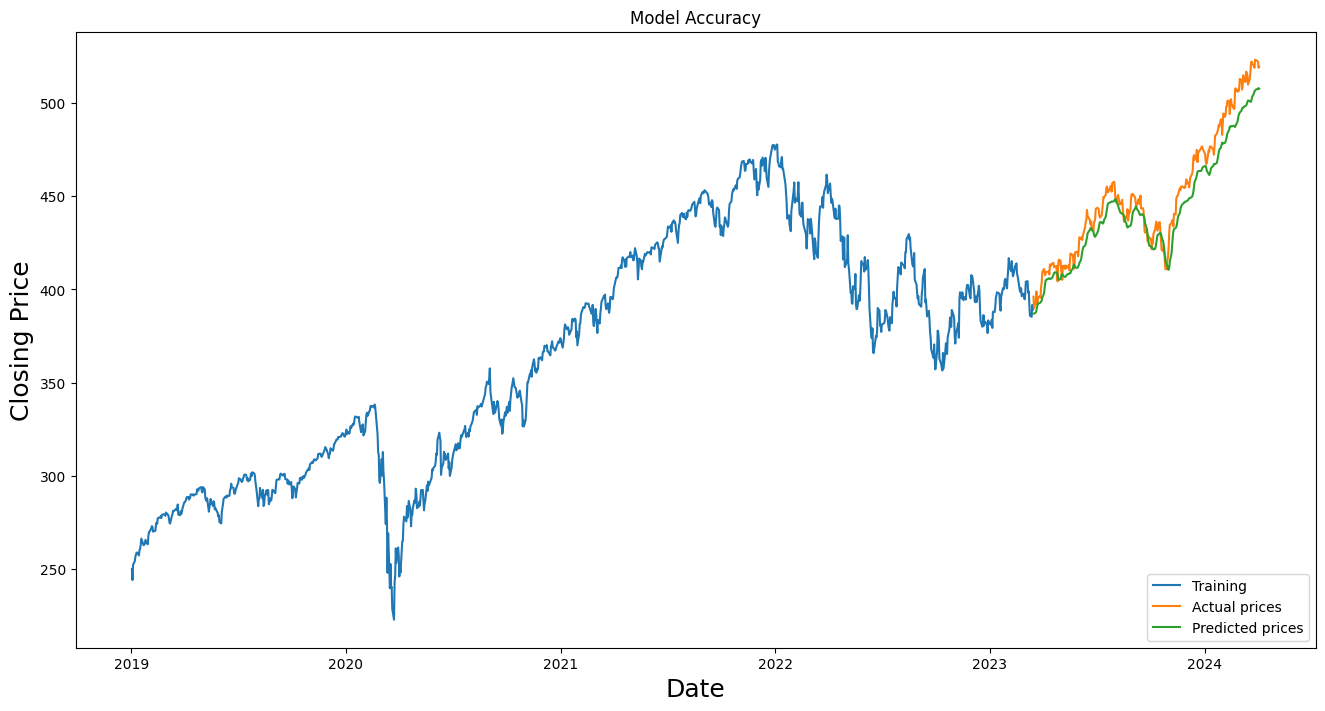

In [16]:
train = df1[:len(training_data)]
test = df1[len(training_data):]
test["Predictions"] = predictions
plt.figure(figsize=(16,8))
plt.title("Model Accuracy")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)
plt.plot(train["Close"])
plt.plot(test[["Close", "Predictions"]])
plt.legend(["Training", "Actual prices", "Predicted prices"], loc="lower right")
plt.show()

In [17]:
user_widget = widgets.BoundedIntText(value=2, min=2, max=100, description="Days: ")
predict_button = widgets.Button(description="Predict")
button_label = widgets.Label(value="Enter a number of days between 2 and 100 for a SPY forecast")

BoundedIntText(value=2, description='Days: ', min=2)

Button(description='Predict', style=ButtonStyle())

Label(value='Enter a number of days between 2 and 100 for a SPY forecast')

1/1 [==============================] - 0s 67ms/step


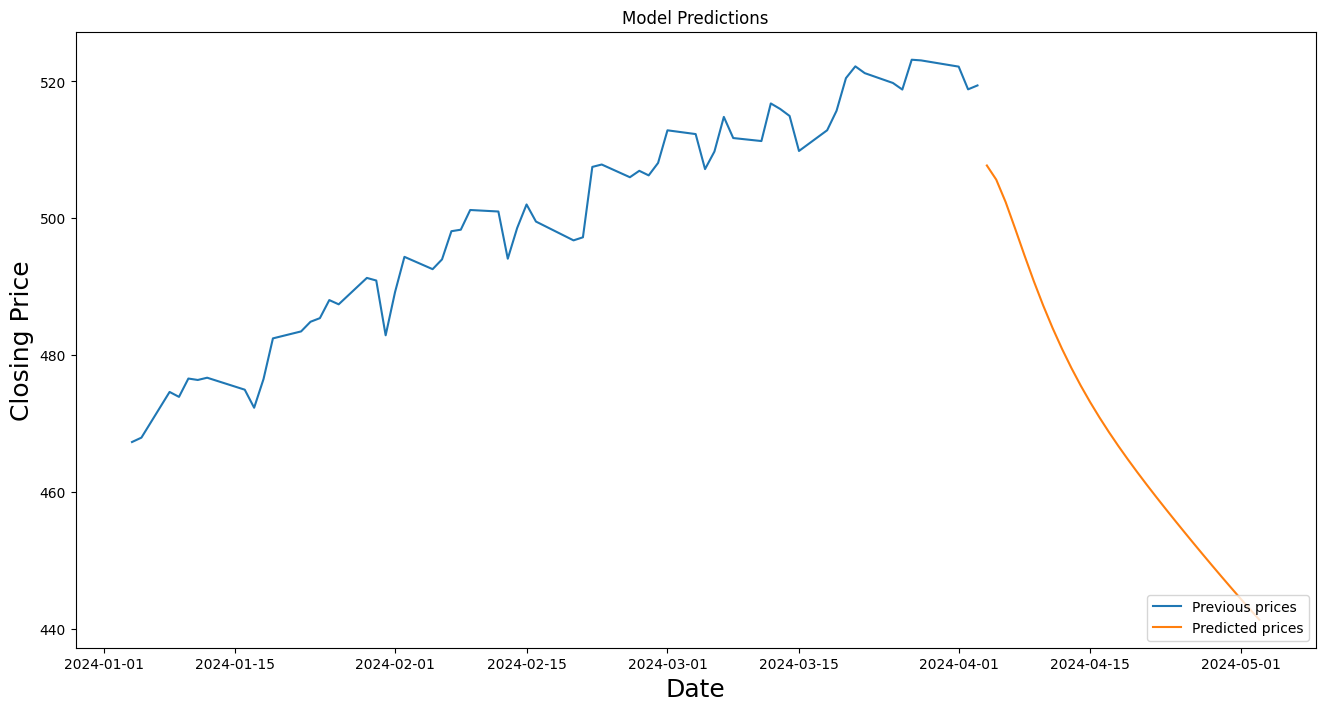

1/1 [==============================] - 0s 50ms/step


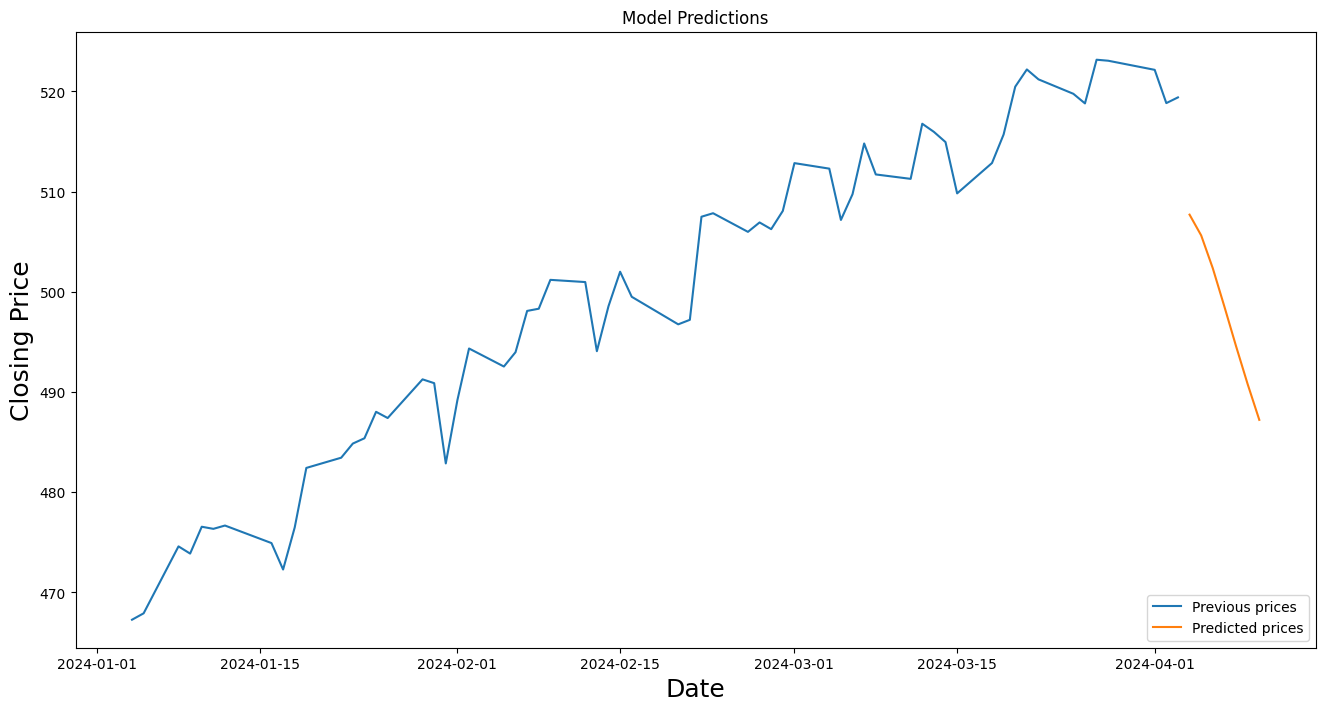

In [18]:
def predict_click(input):
  user = user_widget.value
  user_predictions = np.array([])
  last = x_testing_3d[-1]
  for i in range(user):
    current = model.predict(np.array([last]))
    last = np.concatenate([last[1:], current])
    user_predictions = np.concatenate([user_predictions, current[0]])
  user_predictions = scaler.inverse_transform([user_predictions])[0]

  dates = []
  current_date = df1.index[-1]
  for i in range(user):
    current_date = current_date + timedelta(days=1)
    dates.append({"Date": current_date, "Predictions": user_predictions[i]})
  user_dates = pd.DataFrame(dates).set_index("Date")

  recent = df1[1260:]
  plt.figure(figsize=(16, 8))
  plt.title("Model Predictions")
  plt.xlabel("Date", fontsize=18)
  plt.ylabel("Closing Price", fontsize=18)
  plt.plot(recent["Close"])
  plt.plot(user_dates["Predictions"])
  plt.legend(["Previous prices", "Predicted prices"], loc="lower right")
  plt.show()

predict_button.on_click(predict_click)
display(user_widget, predict_button, button_label)